Plot Tide Forecasts
===================

Plots the daily tidal displacements for a given location

OTIS format tidal solutions provided by Ohio State University and ESR  
- http://volkov.oce.orst.edu/tides/region.html  
- https://www.esr.org/research/polar-tide-models/list-of-polar-tide-models/
- ftp://ftp.esr.org/pub/datasets/tmd/  

Global Tide Model (GOT) solutions provided by Richard Ray at GSFC  

Finite Element Solution (FES) provided by AVISO  
- https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes.html

#### Python Dependencies
 - [numpy: Scientific Computing Tools For Python](https://www.numpy.org)  
 - [scipy: Scientific Tools for Python](https://www.scipy.org/)  
 - [pyproj: Python interface to PROJ library](https://pypi.org/project/pyproj/)  
 - [netCDF4: Python interface to the netCDF C library](https://unidata.github.io/netcdf4-python/)  
 - [matplotlib: Python 2D plotting library](https://matplotlib.org/)  
 - [ipyleaflet: Jupyter / Leaflet bridge enabling interactive maps](https://github.com/jupyter-widgets/ipyleaflet)  

#### Program Dependencies

- `arguments.py`: load the nodal corrections for tidal constituents  
- `astro.py`: computes the basic astronomical mean longitudes  
- `convert_crs.py`: convert points to and from Coordinates Reference Systems  
- `load_constituent.py`: loads parameters for a given tidal constituent  
- `io.model.py`: retrieves tide model parameters for named tide models
- `io.OTIS.py`: extract tidal harmonic constants from OTIS tide models  
- `io.ATLAS.py`: extract tidal harmonic constants from ATLAS netCDF4 tide models  
- `io.GOT.py`: extract tidal harmonic constants from GOT tide models  
- `io.FES.py`: extract tidal harmonic constants from FES tide models  
- `io.constituents.py`: basic tide model constituent class  
- `predict.py`: predict tidal values using harmonic constants  
- `time.py`: utilities for calculating time operations
- `utilities.py`: download and management utilities for files

This notebook uses Jupyter widgets to set parameters for calculating the tidal maps.  

#### Load modules

In [1]:
from __future__ import print_function

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import IPython.display

# import tide programs
import pyTMD.io
import pyTMD.time
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities

import math
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# available model list
model_list = sorted(pyTMD.io.model.ocean_elevation())
# display widgets for setting directory and model
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'GOT4.10'
widgets.VBox([
    TMDwidgets.directory,
    TMDwidgets.model,
    TMDwidgets.atlas,
    TMDwidgets.compress,
    TMDwidgets.datepick
])

In [5]:
# default coordinates to use
LAT,LON = (23.76175,122.26672)
m = pyTMD.tools.leaflet(center=(LAT,LON), zoom=12,
    zoom_control=True, marker_control=True)
# show map
m.map

Map(center=[23.76175, 122.26672], controls=(AttributionControl(options=['position', 'prefix'], position='botto…

[[0.030943674966692924 0.15202389657497406 0.056997451931238174
  0.1767793744802475 0.08910463750362396 0.4602945148944855
  0.18891607224941254 0.05152113735675812 0.0069605265744030476
  0.0009311279281973839]]
[[65.07211380768192 77.45015828198338 96.73382453549121 98.68804410986941
  289.2768677108055 297.7108604300181 322.32758961389067
  322.73642083194557 285.5496812920537 239.01022028769088]]
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's2', 'k2', 's1', 'm4']
-14.6074076711588 -0.4992600751201129 19.033749854136296 19.650166126103386


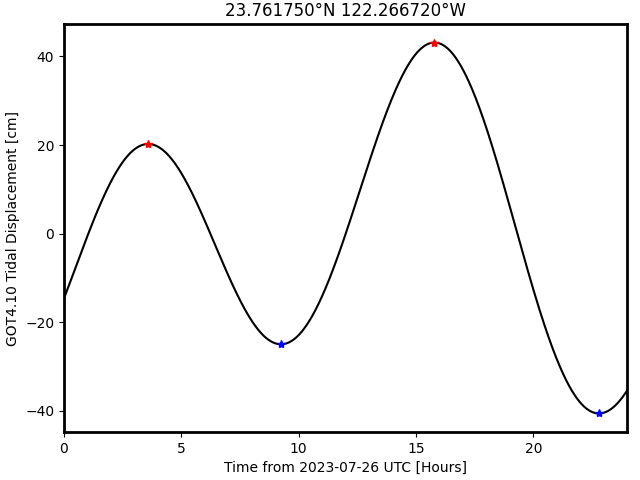

In [6]:
%matplotlib widget

# get model parameters
model = pyTMD.io.model(TMDwidgets.directory.value,
    format=TMDwidgets.atlas.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = TMDwidgets.datepick.value
# calculate a weeks forecast every minute
minutes = np.arange(1*1440)
# convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
tide_time = pyTMD.time.convert_calendar_dates(YMD.year, YMD.month,
    YMD.day, minute=minutes)
hours = minutes/60.0

# create plot with tidal displacements, high and low tides and dates
fig,ax1 = plt.subplots(num=1)
xmax = np.ceil(hours[-1]).astype('i')
l1, = ax1.plot([], [], 'k')
l2, = ax1.plot([], [], 'r*')
l3, = ax1.plot([], [], 'b*')
for h in range(24,xmax,24):
    ax1.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))
ax1.set_xlim(0,xmax)
ax1.set_ylabel(f'{model.name} Tidal Displacement [cm]')
args = (YMD.year,YMD.month,YMD.day)
ax1.set_xlabel('Time from {0:4d}-{1:02d}-{2:02d} UTC [Hours]'.format(*args))
ttl = ax1.set_title(None)
fig.subplots_adjust(left=0.10,right=0.98,bottom=0.10,top=0.95)

# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

# read tidal constants and interpolate to leaflet points
if model.format in ('OTIS','ATLAS','ESR'):
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file, model.model_file,
        model.projection, type=model.type,
        grid=model.format)
    c = constituents.fields
    DELTAT = np.zeros_like(tide_time)
elif (model.format == 'netcdf'):
    constituents = pyTMD.io.ATLAS.read_constants(
        model.grid_file, model.model_file,
        type=model.type, compressed=model.compressed)
    c = constituents.fields
    DELTAT = np.zeros_like(tide_time)
elif (model.format == 'GOT'):
    constituents = pyTMD.io.GOT.read_constants(
        model.model_file, compressed=model.compressed)
    c = constituents.fields
    # interpolate delta times from calendar dates to tide time
    DELTAT = pyTMD.time.interpolate_delta_time(delta_file, tide_time)
elif (model.format == 'FES'):
    constituents = pyTMD.io.FES.read_constants(model.model_file,
        type=model.type, version=model.version,
        compressed=model.compressed)
    c = model.constituents
    # interpolate delta times from calendar dates to tide time
    DELTAT = pyTMD.time.interpolate_delta_time(delta_file, tide_time)

# update the tide prediction and plot
def update_tide_prediction(*args):
    # leaflet location
    LAT,LON = np.copy(m.marker.location)
    # verify longitudes
    LON = m.wrap_longitudes(LON)
    if model.format in ('OTIS','ATLAS','ESR'):
        amp,ph,D = pyTMD.io.OTIS.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, model.projection, type=model.type,
            method='spline', extrapolate=True)
    elif (model.format == 'netcdf'):
        amp,ph,D = pyTMD.io.ATLAS.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, type=model.type, scale=model.scale,
            method='spline', extrapolate=True)
    elif (model.format == 'GOT'):
        amp,ph = pyTMD.io.GOT.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, scale=model.scale,
            method='spline', extrapolate=True)
    elif (model.format == 'FES'):
        amp,ph = pyTMD.io.FES.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, scale=model.scale,
            method='spline', extrapolate=True)
    # calculate complex phase in radians for Euler's
    cph = -1j*ph*np.pi/180.0
    # calculate constituent oscillation
    hc = amp*np.exp(cph)
    print(amp)
    print(ph)
    #c=['m2','k1','s2','o1','n2','k2','p1','q1']
    print(c)
    #f=[]
    #for i in [1,2,3,4,5,6,7]:
    #    amp[i]*math.cos()
    #print(amp*cos())
    # predict tidal elevations at time 1 and infer minor corrections
    TIDE = pyTMD.predict.time_series(tide_time, hc, c,
        deltat=DELTAT, corrections=model.format)
    MINOR = pyTMD.predict.infer_minor(tide_time, hc, c,
        deltat=DELTAT, corrections=model.format)
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    # differentiate to calculate high and low tides
    diff = np.zeros_like(tide_time, dtype=np.float64)
    # forward differentiation for starting point
    diff[0] = TIDE.data[1] - TIDE.data[0]
    # backward differentiation for end point
    diff[-1] = TIDE.data[-1] - TIDE.data[-2]
    # centered differentiation for all others
    diff[1:-1] = (TIDE.data[2:] - TIDE.data[0:-2])/2.0
    # indices of high and low tides
    htindex, = np.nonzero((np.sign(diff[0:-1]) >= 0) & (np.sign(diff[1:]) < 0))
    ltindex, = np.nonzero((np.sign(diff[0:-1]) <= 0) & (np.sign(diff[1:]) > 0))
    # update plot data
    l1.set_data(hours, TIDE.data)
    l2.set_data(hours[htindex], TIDE.data[htindex])
    l3.set_data(hours[ltindex], TIDE.data[ltindex])
    # update plot title
    ttl.set_text(u'{0:0.6f}\u00b0N {1:0.6f}\u00b0W'.format(LAT,LON))
    ax1.relim()
    ax1.autoscale_view()
    fig.canvas.draw()
    print(TIDE[0],TIDE[60],TIDE[180],TIDE[240])

# run tide prediction at initial location
update_tide_prediction()
# watch marker location for changes
m.marker_text.observe(update_tide_prediction)